# How to Download and Prepare Historical Bitcoin Price Data Using Python

In this tutorial, we will download Bitcoin historical data from Yahoo Finance using yfinance, clean it, perform basic feature engineering, and generate useful visualizations to prepare the data for machine learning models.

## Install Required Libraries

In [ ]:
%pip install yfinance matplotlib seaborn pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\bitcoin_forecasting_data_preprocessing\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Import Libraries

In [145]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

plt.style.use("dark_background")
# Create directory to save plots
os.makedirs("figures", exist_ok=True)


## Download Full Historical Bitcoin Price Data

In [146]:
# Download all available BTC-USD historical data
btc = yf.download("BTC-USD", start="2014-01-01")  # Bitcoin price starts around mid-2010

# Process the data
btc.columns = btc.columns.get_level_values(0)
btc = btc[['Open', 'Close', 'Volume', 'Low', 'High']]

# Display first few rows
btc.head()


[*********************100%***********************]  1 of 1 completed


Price,Open,Close,Volume,Low,High
Date,,,,,
2014-09-17,465.864014,457.334015,21056800,452.421997,468.174011
2014-09-18,456.859985,424.440002,34483200,413.104004,456.859985
2014-09-19,424.102997,394.795990,37919700,384.532013,427.834991
2014-09-20,394.673004,408.903992,36863600,389.882996,423.295990
2014-09-21,408.084991,398.821014,26580100,393.181000,412.425995


## Data Summary

### Data Range

In [147]:
print("Data range:", btc.index.min(), "to", btc.index.max())

Data range: 2014-09-17 00:00:00 to 2025-05-25 00:00:00


### Missing Values

In [148]:
btc.isnull().sum()

Price
Open      0
Close     0
Volume    0
Low       0
High      0
dtype: int64

### Data Types

In [149]:
btc.dtypes

Price
Open      float64
Close     float64
Volume      int64
Low       float64
High      float64
dtype: object

### Statistics

In [150]:
btc.describe()

Price,Open,Close,Volume,Low,High
count,3904.000000,3904.000000,3.904000e+03,3904.000000,3904.000000
mean,22307.980589,22334.209713,1.948790e+10,21797.485993,22797.077606
std,25849.156949,25881.277765,2.091782e+10,25297.428221,26382.196871
min,176.897003,178.102997,5.914570e+06,171.509995,211.731003
25%,1923.807495,1973.237457,8.280267e+08,1852.629974,2045.207520
50%,9783.715332,9795.821777,1.565398e+10,9581.794434,9978.582031
75%,36476.639648,36520.551758,3.075392e+10,34935.002930,37471.234375
max,111679.359375,111673.281250,3.509679e+11,109285.070312,111970.171875


## Feature Engineering

### Add daily return


In [151]:
btc["daily_return"] = btc["Close"].pct_change()
btc.dropna(inplace=True)

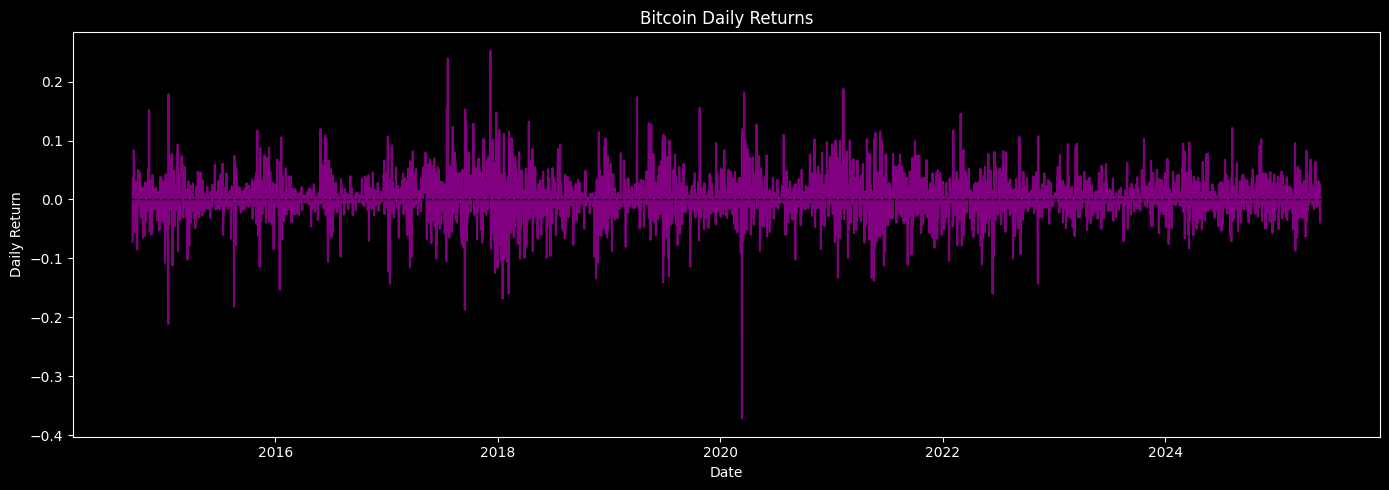

In [152]:
plt.figure(figsize=(14, 5))
plt.plot(btc.index, btc["daily_return"], label="Daily Return", color="purple")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Bitcoin Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.tight_layout()
plt.savefig("figures/btc_daily_returns.png")
plt.show()

### Add Moving Averages

In [153]:
btc["ma_7"] = btc["Close"].rolling(window=7).mean()
btc["ma_30"] = btc["Close"].rolling(window=30).mean()
btc["ma_90"] = btc["Close"].rolling(window=90).mean()
btc.dropna(inplace=True)

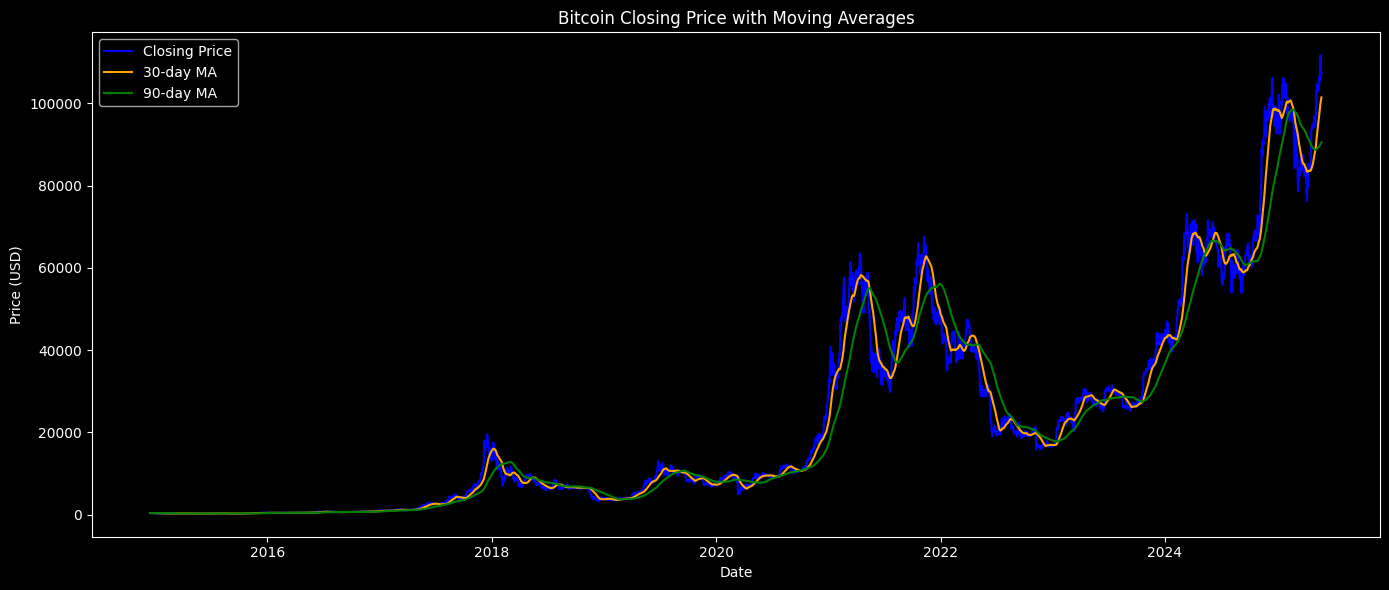

In [154]:
plt.figure(figsize=(14, 6))
plt.plot(btc.index, btc["Close"], label="Closing Price", color="blue")
plt.plot(btc.index, btc["ma_30"], label="30-day MA", color="orange")
plt.plot(btc.index, btc["ma_90"], label="90-day MA", color="green")
plt.title("Bitcoin Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/btc_price_ma.png")
plt.show()

### Bollinger Bands

In [155]:
btc["ma_20"] = btc["Close"].rolling(window=20).mean()
btc["std_20"] = btc["Close"].rolling(window=20).std()
btc["upper_band"] = btc["ma_20"] + 2 * btc["std_20"]
btc["lower_band"] = btc["ma_20"] - 2 * btc["std_20"]
btc.dropna(inplace=True)

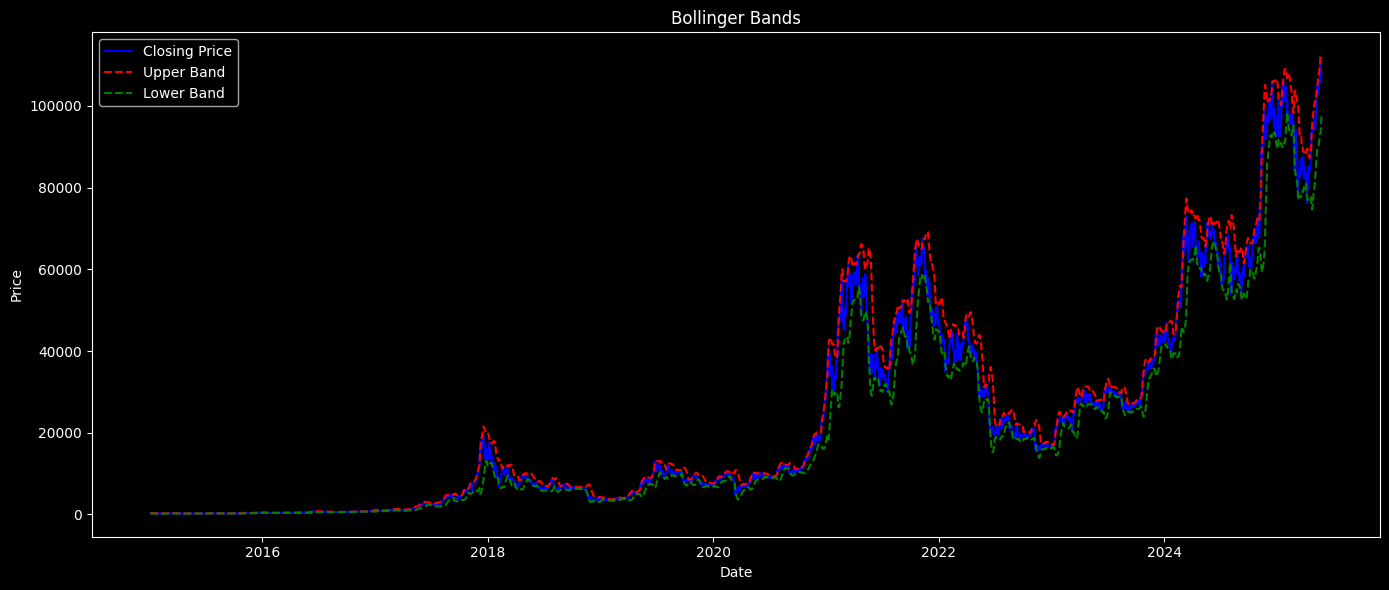

In [156]:
plt.figure(figsize=(14, 6))
plt.plot(btc.index, btc["Close"], label="Closing Price", color="blue")
plt.plot(btc.index, btc["upper_band"], label="Upper Band", linestyle="--", color="red")
plt.plot(btc.index, btc["lower_band"], label="Lower Band", linestyle="--", color="green")
plt.title("Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig("figures/btc_bollinger_bands.png")
plt.show()

### Relative Strength Index (RSI) (14-day)

In [157]:
delta = btc["Close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

avg_gain = pd.Series(gain, index=btc.index).rolling(window=14).mean()
avg_loss = pd.Series(loss, index=btc.index).rolling(window=14).mean()

rs = avg_gain / avg_loss
btc["rsi_14"] = 100 - (100 / (1 + rs))


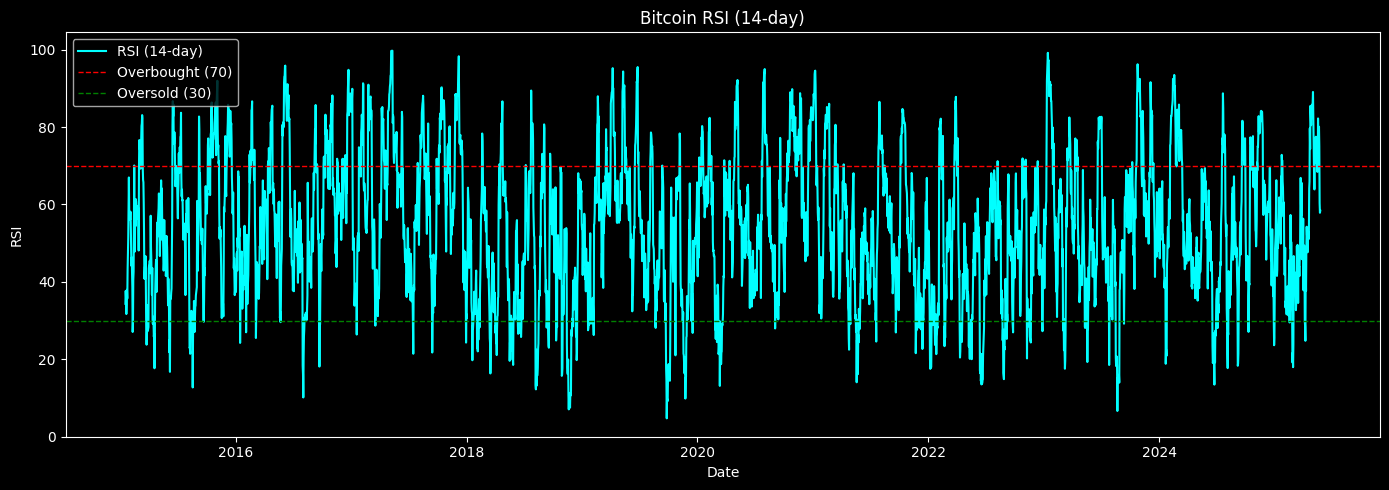

In [158]:
plt.figure(figsize=(14, 5))
plt.plot(btc.index, btc["rsi_14"], label="RSI (14-day)", color="cyan")
plt.axhline(70, color="red", linestyle="--", linewidth=1, label="Overbought (70)")
plt.axhline(30, color="green", linestyle="--", linewidth=1, label="Oversold (30)")
plt.title("Bitcoin RSI (14-day)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("figures/btc_rsi_14.png")
plt.show()

### Add Volatility (Rolling Std Dev)

In [159]:
btc["volatility_30"] = btc["daily_return"].rolling(window=30).std()
btc.dropna(inplace=True)

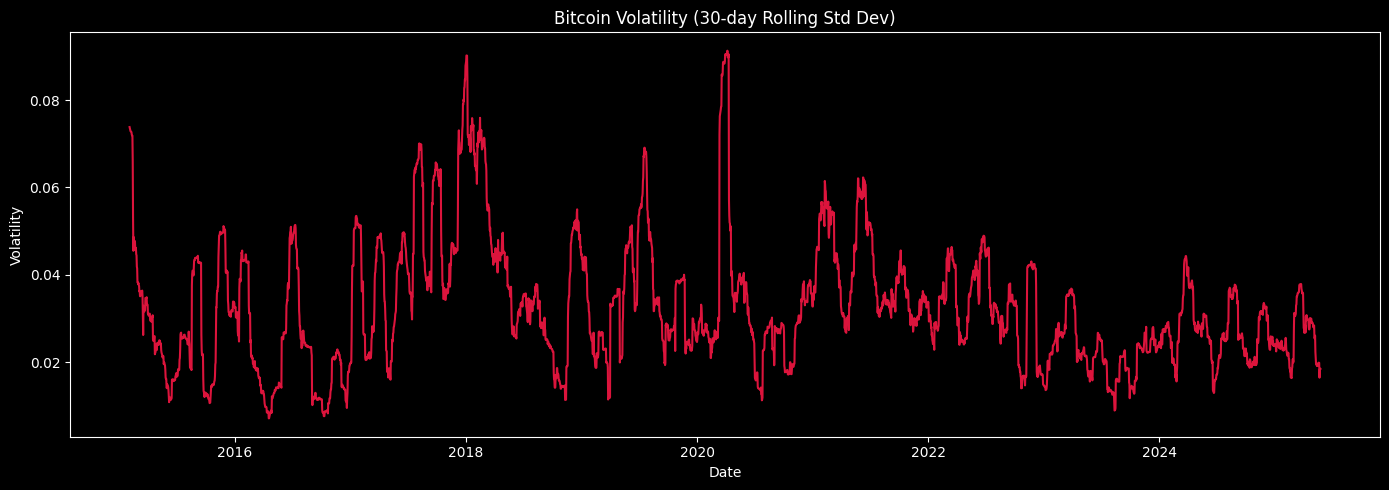

In [160]:
plt.figure(figsize=(14, 5))
plt.plot(btc.index, btc["volatility_30"], label="30-Day Rolling Volatility", color="crimson")
plt.title("Bitcoin Volatility (30-day Rolling Std Dev)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()
plt.savefig("figures/btc_volatility.png")
plt.show()


## Save Data with Engineered Features

In [161]:
# Save feature-enhanced data
btc.to_csv("btc_features.csv", index=False)

features = btc.columns.tolist()

btc[features].tail()

Price,Open,Close,Volume,Low,High,daily_return,ma_7,ma_30,ma_90,ma_20,std_20,upper_band,lower_band,rsi_14,volatility_30
Date,,,,,,,,,,,,,,,
2025-05-21,106791.312500,109678.078125,78086364051,106127.234375,110724.460938,0.027034,105563.766741,99478.483333,89889.102691,102009.212109,4411.895897,110833.003904,93185.420315,80.107099,0.019807
2025-05-22,109673.492188,111673.281250,70157575642,109285.070312,111970.171875,0.018191,106696.429688,100086.196354,90061.855295,102747.372656,4736.904653,112221.181963,93273.563350,75.113611,0.016413
2025-05-23,111679.359375,107287.796875,67548133399,106841.304688,111798.906250,-0.039271,107239.073661,100539.152604,90180.855729,103317.172656,4550.593600,112418.359857,94215.985456,60.326520,0.018382
2025-05-24,107278.507812,107791.156250,45903627163,106895.289062,109454.523438,0.004692,107896.226562,101000.731250,90308.825000,103990.931641,4125.441698,112241.815037,95740.048245,57.862833,0.018378
2025-05-25,107789.937500,107379.914062,47139233792,106725.562500,108269.789062,-0.003815,108029.641741,101422.711719,90486.177691,104622.524609,3564.756940,111752.038490,97493.010729,58.393135,0.018431


## Correlation Heatmap of Features

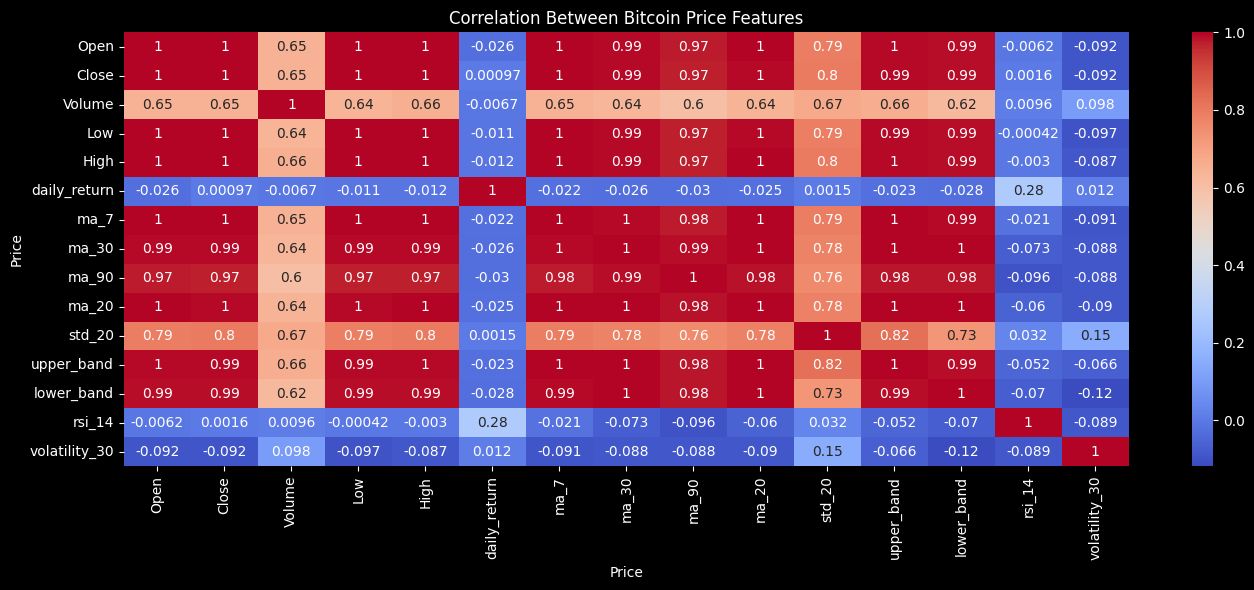

In [163]:
plt.figure(figsize=(14, 6))
sns.heatmap(btc[features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Bitcoin Price Features")
plt.tight_layout()
plt.savefig("figures/btc_correlation_heatmap.png")
plt.show()